In [1]:
import os
import re
import json
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

In [30]:
import numpy as np

def listes_binaire_par_valeur(lst):
    arr = np.array(lst)
    indices_dict = {}
    for val in np.unique(arr):
        binaire = np.zeros(len(arr), dtype=int)  # Crée une liste de zéros de taille 512
        binaire[np.where(arr == val)[0]] = 1     # Met un 1 aux indices correspondant à la valeur
        indices_dict[val] = binaire.tolist()
    return indices_dict

# Exemple d'utilisation :
lst = [0, 1, 0, 1, 3, 0, 3, 1, 0, 1, 0, 0, 0, 0, 2, 3, 2, 1, 0, 0]
result = listes_binaire_par_valeur(lst)
print(result)


{0: [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1], 1: [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], 3: [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]}


In [31]:
import numpy as np

# Création de deux grands np.array contenant des sous-np.array
array1 = np.array([np.array([1, 2]), np.array([3, 4])], dtype=object)
array2 = np.array([np.array([5, 6]), np.array([7, 8])], dtype=object)

# Concaténation des deux grands tableaux
result = np.concatenate((array1, array2), axis=0)

print(result)


[[1 2]
 [3 4]
 [5 6]
 [7 8]]


In [2]:
def list_files(directory, extension:str=".npz"):
    """Liste tous les fichiers .npz dans le dossier spécifié."""
    return [f for f in os.listdir(directory) if f.endswith(extension)]

In [3]:
def load_and_process_flat(file_name : str,
                          base_path,
                          layer_name : str = "layer_40"):
    data = np.load(f"{base_path}/heatmap/{file_name}")
    heatmaps = data[layer_name]
    heatmaps = np.abs(heatmaps)
    heatmaps_flat = heatmaps.reshape(heatmaps.shape[0], -1)
    return heatmaps, heatmaps_flat

In [21]:
def get_feature_per_cluster(data, best_number_cluster, best_method, picture_name, base_path):
    cluster_label = data[f"{best_number_cluster}_{best_method}"]
    print(cluster_label)
    index_in_each_cluster = indices_par_valeur(cluster_label)
    print(index_in_each_cluster)
    heatmaps, _ = load_and_process_flat(picture_name, base_path, layer_name="layer_40")
    heatmaps_by_cluster = {}
    vmin, vmax = float("inf"), float("-inf")
    for cluster in set(cluster_label):
        if cluster == -1:
            continue
        indices = np.where(cluster_label == cluster)[0]
        cluster_heatmaps = heatmaps[indices]
        heatmaps_by_cluster[cluster] = cluster_heatmaps

        if cluster_heatmaps.shape[0] > 0:
            combined_heatmap = np.sum(cluster_heatmaps, axis=0)
            vmin = min(vmin, combined_heatmap.min())
            vmax = max(vmax, combined_heatmap.max())
    return heatmaps_by_cluster, vmin, vmax, index_in_each_cluster

In [5]:
def indices_par_valeur(lst):
    arr = np.array(lst)
    return {val: np.where(arr == val)[0].tolist() for val in np.unique(arr)}

In [6]:
def get_filename_without_extension(path: str) -> str:
    return os.path.splitext(os.path.basename(path))[0]

In [7]:
def get_all_different_element_in_cluster_meaning(dictionnary_file_to_clusters_meaning):
    all_values = []
    for key_file_name in dictionnary_file_to_clusters_meaning:
        for _, value in dictionnary_file_to_clusters_meaning[key_file_name].items():
            if value not in all_values:
                all_values.append(value)
    return all_values

In [8]:
def extract_code(filename: str) -> str:
    match = re.match(r"(n\d+)_", filename)
    return match.group(1) if match else ""

In [9]:
def reverse_dict_list(d):
    reversed_dict = {}
    for key, values in d.items():
        for value in values:
            reversed_dict[value] = key
    return reversed_dict

In [10]:
def get_colors(n, cmap_name='tab10'):
    cmap = cm.get_cmap(cmap_name, n)  # Obtenir la colormap avec n couleurs distinctes
    return [cmap(i) for i in range(n)]

In [11]:
def compare_2_dict(dictionary_comparison_2_files : dict,
                           list_colors : list = None,
                           dictionary_class_index : dict = None):
    file_name1, file_name2 = dictionary_comparison_2_files[FILE_NAME_CONST]
    index_in_each_cluster1, index_in_each_cluster2 = dictionary_comparison_2_files[INDEX_IN_EACH_CLUSTER_CONST]
    dict_equivalence1, dict_equivalence2 = dictionary_comparison_2_files[DICTIONARY_EQUIVALENCE_CONST]
    all_values = dictionary_comparison_2_files[ALL_VALUES_CONST]
    class_name_1 = extract_code(file_name1)
    class_name_2 = extract_code(file_name2)
    if list_colors is None:
        list_colors = get_colors(len(index_in_each_cluster2))
    if dictionary_class_index is None:
        class_name_1 = ""
        class_name_2 = ""
    else :
        class_name_1 = dictionary_class_index[class_name_1]
        class_name_2 = dictionary_class_index[class_name_2]

    reversed_dict_1 = reverse_dict_list(index_in_each_cluster1)
    global_dict = {class_name: [0] * len(index_in_each_cluster2) for class_name in all_values}

    for i, (key2, indices) in enumerate(index_in_each_cluster2.items()):
        for index in indices:
            class_name_dict1 = dict_equivalence1.get(reversed_dict_1.get(index))
            if class_name_dict1:
                global_dict[class_name_dict1][i] += 1

    x = range(len(all_values))
    bottom = [0] * len(all_values)

    plt.figure(figsize=(10, 6))

    for i, (key2, color) in enumerate(zip(index_in_each_cluster2.keys(), list_colors)):
        values = [global_dict[class_name][i] for class_name in all_values]
        bars = plt.bar(x, values, bottom=bottom, label=dict_equivalence2[key2], color=color)

        for bar, value in zip(bars, values):
            if value > 0:
                plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                         str(value), ha='center', va='center', fontsize=9, color='black')

        bottom = [b + v for b, v in zip(bottom, values)]

    for i, total in enumerate(bottom):
        if total > 0:
            plt.text(i, total, str(total), ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xticks(x, all_values, rotation=45)
    plt.xlabel(f"Classes de {file_name1} ({class_name_1})")
    plt.ylabel(f"Nombre d'éléments")
    plt.title(f"Comparaison des classes entre {file_name1} ({class_name_1}) et {file_name2} ({class_name_2})")
    plt.legend(title=f"Classes de {file_name2} ({class_name_2})")
    plt.tight_layout()
    plt.show()

In [12]:
def compare_X_dict(dictionnary_file_to_clusters_meaning: dict,
                              dictionary_file_to_index_in_each_cluster: dict,
                              all_values: list,
                              base_path : str,
                              save_name_prefix : str,
                              list_colors: list = None,
                              dictionary_class_index: dict = None,
                              seuil_to_None : int = 1,
                              seuil_is_mean : bool = False,
                              save_files : bool = True):
    class_name_to_id = {class_name: i for i, class_name in enumerate(all_values)}
    class_id_to_name = {i: class_name for i, class_name in enumerate(all_values)}

    global_dict = {class_name: [0] * (len(list(dictionnary_file_to_clusters_meaning.keys()))+1) for class_name in all_values}
    local_dict = {}
    local_dict_max = {}
    class_id_to_all_features = {class_name: [] for class_name in all_values}

    for file_name in dictionnary_file_to_clusters_meaning.keys():
        for class_id in dictionnary_file_to_clusters_meaning[file_name].keys():
            class_name = dictionnary_file_to_clusters_meaning[file_name][class_id]
            list_feature_id = dictionary_file_to_index_in_each_cluster[file_name][class_id]

            for feature_id in list_feature_id:
                if feature_id not in local_dict:
                    local_dict[feature_id] = [0] * len(all_values)

                class_id = class_name_to_id[class_name]
                local_dict[feature_id][class_id] += 1

    if seuil_is_mean:
        seuil_to_None = len(dictionnary_file_to_clusters_meaning.keys()) // 2

    for feature_id in local_dict.keys():
        occurrences = local_dict[feature_id]
        best_index = occurrences.index(max(occurrences))
        nb_occurrence = occurrences[best_index]

        if nb_occurrence <= seuil_to_None:
            best_index = class_name_to_id[CLUSTER_FEATURE_NONE]

        local_dict_max[feature_id] = (best_index, nb_occurrence)  # (index de la classe, nombre d'occurrences)
        class_name = class_id_to_name[best_index]
        class_id_to_all_features[class_name].append(feature_id)

        if nb_occurrence < len(global_dict[class_name]):
            global_dict[class_name][nb_occurrence] += 1

    if save_files:
        save_dir = os.path.join(base_path, "clusters_analysis")
        os.makedirs(save_dir, exist_ok=True)

        np.savez(os.path.join(save_dir, f"{save_name_prefix}_{SUFFIX_NB_LEVEL_OCCURENCE_PER_CLASS}.npz"), **global_dict)
        np.savez(os.path.join(save_dir, f"{save_name_prefix}_{SUFFIX_CLASS_AND_OCCURENCE_PER_FEATURE}.npz"), **{str(k): v for k, v in local_dict_max.items()})
        np.savez(os.path.join(save_dir, f"{save_name_prefix}_{SUFFIX_ALL_FEATURE_IN_EACH_CLASS}.npz"), **{str(k): v for k, v in class_id_to_all_features.items()})

    if list_colors is None:
        cmap = plt.get_cmap('viridis')
        list_colors = [cmap(i / (len(all_values))) for i in range(len(all_values))]

    class_names = list(global_dict.keys())
    occurrence_levels = list(range(1, len(list(dictionnary_file_to_clusters_meaning.keys()))+1))
    bottom = [0] * len(class_names)

    plt.figure(figsize=(12, 7))

    for occ_level, color in zip(occurrence_levels, list_colors):
        values = [global_dict[class_name][occ_level] for class_name in class_names]
        bars = plt.bar(class_names, values, bottom=bottom, color=color, label=f"{occ_level} occurrence{'s' if occ_level != 1 else ''}")

        for bar, value in zip(bars, values):
            if value > 0:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, str(value), ha='center', va='center', fontsize=9)


        bottom = [sum(x) for x in zip(bottom, values)]

    plt.xlabel('Classes')
    plt.ylabel('Nombre de caractéristiques')
    plt.title('Distribution empilée des occurrences par classe')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Nombre d'occurrences")
    plt.tight_layout()
    plt.show()




In [13]:
SUFFIX_NB_LEVEL_OCCURENCE_PER_CLASS = "nb_level_occurence_per_class"
SUFFIX_CLASS_AND_OCCURENCE_PER_FEATURE = "class_and_occurence_per_feature"
SUFFIX_ALL_FEATURE_IN_EACH_CLASS = "all_feature_in_each_class"

In [14]:
GMM_CONST = "GMM"
KMEANS_CONST = "KMeans"
SPECTRAL_CONST = "SpectralClustering"
AGGLOMERATIVE_CONST = "AgglomerativeClustering"
HDBSCAN_CONST = "HDBSCAN"

In [15]:
CLUSTER_FEATURE_NONE = "None"
CLUSTER_FEATURE_EYE = "Eye"
CLUSTER_FEATURE_HEAD = "Head"
CLUSTER_FEATURE_BODY = "Body"
CLUSTER_FEATURE_BEAK = "Beak"
CLUSTER_FEATURE_WING = "Wing"
CLUSTER_FEATURE_TAIL = "Tail"
CLUSTER_FEATURE_LEG = "Leg"

In [16]:
dictionary_file_to_best_clustering = {
    "n01829413_46" : (4, KMEANS_CONST),
    "n01829413_5429" : (4, KMEANS_CONST),
}

In [17]:
dictionnary_file_to_clusters_meaning = {
    "n01829413_46" : {
        0: CLUSTER_FEATURE_NONE,
        1: CLUSTER_FEATURE_EYE,
        2: CLUSTER_FEATURE_BEAK,
        3: CLUSTER_FEATURE_WING,
    },
    "n01829413_5429" : {
        0: CLUSTER_FEATURE_WING,
        1: CLUSTER_FEATURE_TAIL,
        2: CLUSTER_FEATURE_EYE,
        3: CLUSTER_FEATURE_NONE,
    },
}

In [18]:
base_path = "./data/v6/clusters"

In [19]:
directory_clusters = f"{base_path}/clusters"
files_clusters = list_files(directory_clusters, extension=".npz")

In [20]:
with open(f"{base_path}/imagenet_class_index_reversed.json", "r") as file:
    dictionary_class_index = json.load(file)

In [22]:
dictionary_file_to_index_in_each_cluster = {}
for picture_name in dictionary_file_to_best_clustering.keys():
    file_path_cluster = f"{directory_clusters}/clusters_{picture_name}.npz"
    if not os.path.exists(file_path_cluster):
        print(f"File {file_path_cluster} does not exist.")
        continue
    best_number_cluster, best_method = dictionary_file_to_best_clustering[picture_name]
    data = np.load(file_path_cluster)
    heatmap_file = f"{picture_name}.npz"
    _, _, _, index_in_each_cluster = get_feature_per_cluster(data, best_number_cluster, best_method, heatmap_file, base_path)
    dictionary_file_to_index_in_each_cluster[picture_name] = index_in_each_cluster

[0 1 0 1 3 0 3 1 0 1 0 0 0 0 2 3 2 1 0 0 2 2 0 2 1 1 2 1 0 3 2 1 1 1 1 2 1
 3 1 3 1 1 0 2 3 1 0 1 1 1 2 0 0 1 1 2 0 0 3 3 2 0 1 1 3 0 1 3 2 0 1 1 1 1
 1 1 1 2 2 1 1 0 2 0 0 2 0 1 0 2 1 1 1 1 1 0 2 1 1 1 1 0 2 1 3 2 1 1 3 1 1
 2 1 0 1 3 2 1 3 3 2 1 1 1 0 0 1 2 1 1 1 3 2 3 1 3 2 1 0 0 2 3 1 2 1 1 1 1
 2 1 1 2 1 1 2 0 1 0 1 1 2 3 2 1 1 1 1 2 0 1 0 1 1 1 2 0 3 1 1 1 3 1 1 0 2
 1 1 1 3 3 0 0 1 1 1 0 1 3 3 1 0 0 1 1 3 1 1 1 1 3 1 3 1 1 1 1 1 1 3 1 2 2
 2 1 0 0 0 3 1 0 2 1 2 1 1 1 1 2 2 3 0 1 1 1 1 0 2 1 0 3 1 3 2 1 1 1 1 1 3
 3 3 1 1 1 0 2 3 1 2 1 1 2 0 1 0 2 1 1 2 1 3 1 0 1 2 1 2 2 1 1 2 1 3 2 0 2
 2 0 3 0 2 3 1 3 0 0 1 2 1 1 2 1 0 1 3 3 2 3 1 0 3 0 1 3 1 0 2 2 3 3 0 2 0
 1 1 1 1 3 2 3 1 3 3 0 2 1 1 1 1 1 2 1 1 0 3 0 2 1 3 0 0 2 0 2 0 2 1 3 2 3
 1 1 3 0 3 1 1 1 1 2 1 3 2 1 1 3 0 1 1 0 1 1 1 0 1 1 2 2 0 0 1 2 3 1 2 3 1
 0 0 3 2 1 3 2 1 0 2 1 1 1 2 0 1 1 1 2 1 1 2 2 1 0 1 3 0 1 3 3 2 3 0 3 0 3
 1 3 1 3 3 0 2 3 1 0 1 2 0 2 0 1 3 2 1 1 3 3 3 3 1 3 1 2 3 0 2 3 2 0 2 1 1
 0 2 1 2 3 1 3 3 1 3 2 1 

In [23]:
import numpy as np

def listes_binaire_par_valeur(lst):
    arr = np.array(lst)
    indices_dict = {}
    for val in np.unique(arr):
        binaire = np.zeros(len(arr), dtype=int)  # Crée une liste de zéros de taille 512
        binaire[np.where(arr == val)[0]] = 1     # Met un 1 aux indices correspondant à la valeur
        indices_dict[val] = binaire.tolist()
    return indices_dict

# Exemple d'utilisation :
lst = [0, 1, 0, 1, 3, 0, 3, 1, 0, 1, 0, 0, 0, 0, 2, 3, 2, 1, 0, 0]
result = listes_binaire_par_valeur(lst)
print(result)


{0: [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1], 1: [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], 3: [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]}


In [24]:
all_values = get_all_different_element_in_cluster_meaning(dictionnary_file_to_clusters_meaning)

In [27]:

dictionary_file_to_best_clustering = {
    "n02423022_1601": (3, KMEANS_CONST),
    "n02423022_1721": (6,KMEANS_CONST),
    "n02423022_5834": (2, KMEANS_CONST),
    "n02423022_219": (5, KMEANS_CONST),
    "n02423022_425": (7, KMEANS_CONST),
    "n02423022_950": (8, KMEANS_CONST),
    "n02423022_1719": (4, KMEANS_CONST),
    "n02423022_2853": (9, KMEANS_CONST),
    "n02423022_3333": (5, KMEANS_CONST),
    "n02423022_26471": (7,KMEANS_CONST),
    "n02423022_2925": (2, KMEANS_CONST),
    "n02423022_10849": (2,KMEANS_CONST),
    "n02423022_39890": (6,KMEANS_CONST),
    "n02423022_976": (3, KMEANS_CONST),
    "n02423022_26532": (4,KMEANS_CONST),
    "n02423022_3614": (8,KMEANS_CONST),
    "n02423022_933": (13,KMEANS_CONST),
    "n02423022_418": (3, KMEANS_CONST),
    "n02423022_3341": (2, KMEANS_CONST),
    "n02423022_6092": (2, KMEANS_CONST),
    "n02423022_11080": (7, KMEANS_CONST),
    "n02423022_233": (3, KMEANS_CONST),
    "n02423022_9189": (6, KMEANS_CONST),
    "n02423022_4539": (2, KMEANS_CONST),
    "n02423022_2640": (3, KMEANS_CONST),
}
print(len(dictionary_file_to_best_clustering.keys()))

25


In [25]:
colors = [
    "#E6194B",  # Rouge vif
    "#3CB44B",  # Vert vif
    "#FFE119",  # Jaune
    "#4363D8",  # Bleu vif
    "#F58231",  # Orange
    "#911EB4",  # Violet
    "#46F0F0",  # Cyan
    "#F032E6",  # Rose
    "#BCF60C",  # Vert clair
    "#FABEBE"   # Rose clair
]

In [26]:
FILE_NAME_CONST = "file_name"
INDEX_IN_EACH_CLUSTER_CONST = "index_in_each_cluster"
DICTIONARY_EQUIVALENCE_CONST = "dictionary_equivalence"
ALL_VALUES_CONST = "all_values"

In [27]:
dictionary_comparison_2_files = {}

If you want to compare two files, you can use the following code.

In [57]:
first_picture_to_compare = "n01829413_46"
second_picture_to_compare = "n01829413_5429"

In [58]:
index_in_each_cluster_1 = dictionary_file_to_index_in_each_cluster[first_picture_to_compare]
index_in_each_cluster_2 = dictionary_file_to_index_in_each_cluster[second_picture_to_compare]

In [59]:
dict_equivalence_1 = dictionnary_file_to_clusters_meaning[first_picture_to_compare]
dict_equivalence_2 = dictionnary_file_to_clusters_meaning[second_picture_to_compare]

In [60]:
dictionary_comparison_2_files[FILE_NAME_CONST] = (first_picture_to_compare, second_picture_to_compare)
dictionary_comparison_2_files[INDEX_IN_EACH_CLUSTER_CONST] = (index_in_each_cluster_1, index_in_each_cluster_2)
dictionary_comparison_2_files[DICTIONARY_EQUIVALENCE_CONST] = (dict_equivalence_1, dict_equivalence_2)
dictionary_comparison_2_files[ALL_VALUES_CONST] = all_values

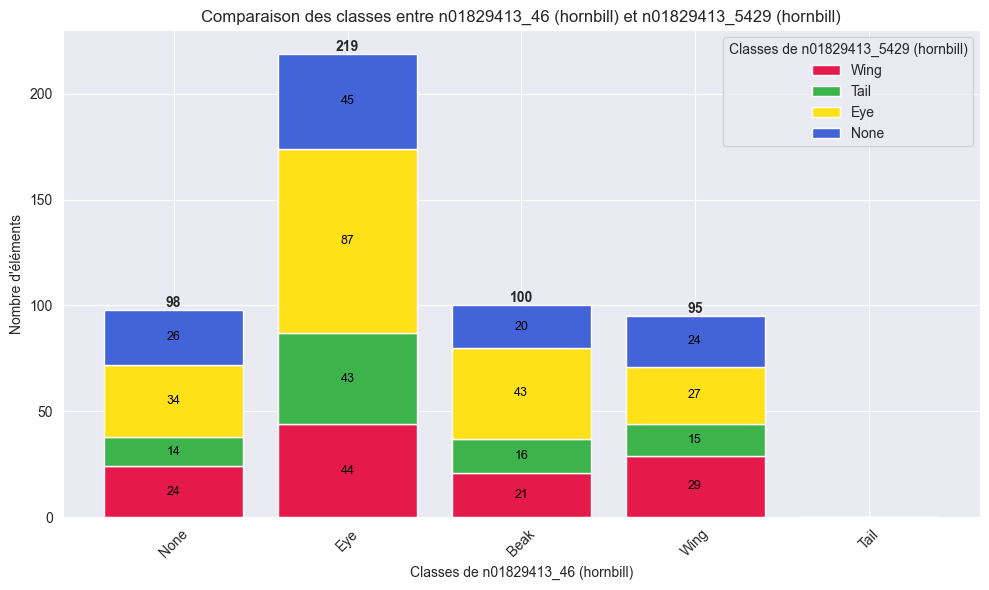

In [61]:
compare_2_dict(dictionary_comparison_2_files, list_colors= colors, dictionary_class_index=dictionary_class_index)

If you want to compare multiple file and each feature is assigned to the cluster where it is the most frequent, you can use the following code.
If it appears 1 times everywhere it is assigned to the None cluster
If it appears in equal proportion in multiple clusters, it is assigned to the first cluster where it appear in such proportion

Modifie le nom dans save_name_prefix pour modifier le nom sous lesquel ce sera sauvegardé (mets un truc pas trop long)
seuil_to_None permet de fdéfinir à partir de combien d'occurence on garde dans la class. Si par exemple tu mets 2 et que l'occurrence max d'une feature est 1 alors elle sera mise dans None
seuil_is_mean permet de remplacer seuil_to_None pour définir directement seuil_to_None comme étant la moyenne arrondi à l'inférieur du nombre de fichier traiter (le nombre de clef dns dictionnary_file_to_clusters_meaning)

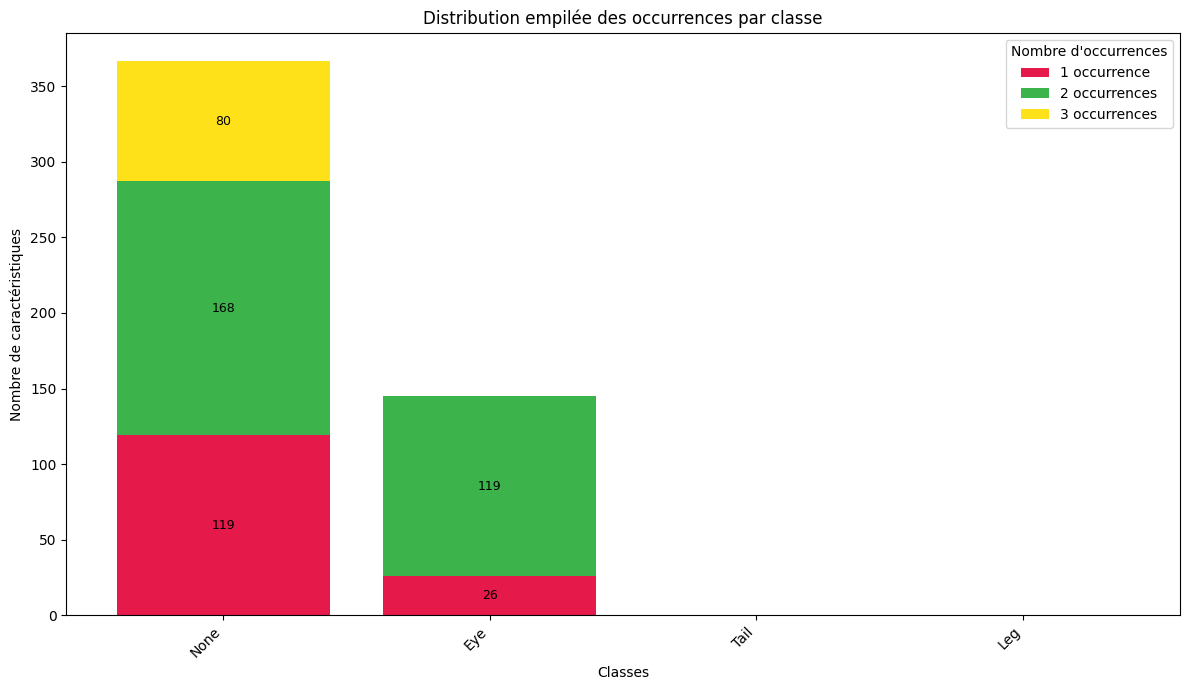

In [31]:
compare_X_dict(dictionnary_file_to_clusters_meaning, dictionary_file_to_index_in_each_cluster, all_values, list_colors=colors, dictionary_class_index=dictionary_class_index, seuil_to_None = 0, base_path = base_path, save_name_prefix = "t1")

DEssous : si apparait une fois : déplacer dans None cluster

In [ ]:
compare_X_dict(dictionnary_file_to_clusters_meaning, dictionary_file_to_index_in_each_cluster, all_values, list_colors=colors, dictionary_class_index=dictionary_class_index, base_path = base_path, save_name_prefix = "e1_seuil1", seuil_is_mean = True)